In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize
import math
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Simulating volatility surfaces

Functions to make some necessary computations in order to simulate volatility surfaces

In [2]:
#function for computing Black Scholes price
def bs_price(vol, initial_price, r, T, K):
    
    d1=np.log(initial_price/K) + (r+(vol*vol)/2)*T
    d1=d1/(vol*np.sqrt(T))
    if (np.isinf(d1).any())==True:
        return -1
      #  return np.nan()

    d2=d1- vol*np.sqrt(T)

    vanilla_price=initial_price*stats.norm.cdf(d1)- K*np.exp(-r*T)*stats.norm.cdf(d2)
    return vanilla_price


#given the BS parameters and the observed price for an option with these parameters, this function
#returns the difference between observed and theoretical price through BS equation.
def bs_price_brent(vol, initial_price, r, T, K, observed_price):
    vanilla_price=bs_price(vol,initial_price,r,T,K)
    
    return vanilla_price-observed_price       


#a function that calls optimize.brentq in order to find 0s for the bs_price_brent function (solving for the implied vol). 
#Given the observed data we compute the volatility that equals theoretical price to observed -> Implied
#volatility. The minimum vol is defined as 0.001 and max as 100(10.000%). 
#If optimize brent does not find a solution it means that the theoretical price with volatility=0% is higher than 
#the observed price and a 0 can not be found, therefore we assume vol=0
def implied_vol(initial_price,r,T,K, observed_price):
    try:
        vol=optimize.brentq(bs_price_brent,0.001,100,(initial_price,r,T,K,observed_price))#0=0%, 1=100%, 100=10.000%
        
    except:
        vol=0
    return vol



#### Theoretical BS surface

Implied volatiliy surface for vanilla options satisfying the Black-Scholes assumptions.

- Initial price/$S_0$: 250
- $\sigma$: 0.2
- Risk-free rate/r: 0.1

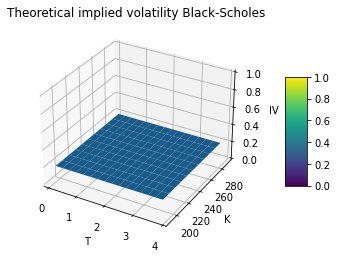

In [3]:
initial_price=250
vol=0.2
r=0.1

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Create data and meshgrid to be plotted
T = np.arange(0.1, 4, 0.25)
K = np.arange(190, 300, 10)

T, K = np.meshgrid(T, K)

P = bs_price(vol,initial_price, r, T,K)#theoretical BS price
IV=np.empty_like(P) #to store implied volatilities

#iterate through the T,K meshgrid and compute each implied vol
size=T.shape
for i in range (size[0]):
    for j in range(size[1]):
        IV[i][j]= implied_vol(initial_price,r,T[i][j],K[i][j],P[i][j])


# Plot the surface.
surf = ax.plot_surface(T, K, IV) #color="r"

# Customize the z axis.
ax.set_zlim(0, 1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.12)

#Axis and titles
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('IV')
plt.title("Theoretical implied volatility Black-Scholes")

#plt.savefig('FlatSurface.png')
plt.show()

#### GBM implied volatility surface with simulated data

Simulating payoffs of an asset following a GBM. For each combination of T and K I will compute 15000 payoffs and take the mean as an observed price in the market for that option.

In [4]:
#simulate a stock following a geometric brownian motion
def stock_simulation_GBM(initial_price, vol, r, T):
    n=1000
    dt=T/n
    
    time=[0]*n
    bt=[0]*n
    S=[0]*n
    S[0]=initial_price

    for i in range(1,len(bt)):
        time[i]=time[i-1]+dt
        bt[i]=bt[i-1]+np.random.normal(0,np.sqrt(dt))
        dB=bt[i]-bt[i-1]

        dS=(r*S[i-1]*dt)+(vol*S[i-1]*dB)
        S[i]=S[i-1]+dS
            
    last_price=S[-1]
          
    return last_price

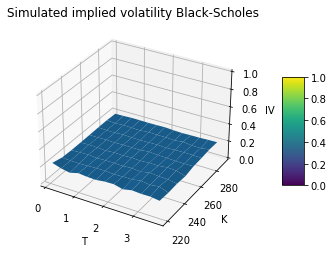

In [12]:
initial_price=250
vol=0.2
r=0.1


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

T = np.arange(0.1,4,0.3)
K = np.arange(220, 300, 10) #strikes 10,630
T, K = np.meshgrid(T, K)
size=T.shape

P=0#prices for each T and K

#at each iteration a payoff for each T and K is computed
m=15000
for i in range(m):
    F=stock_simulation_GBM(initial_price, vol, r, T)
    
    #compute payoff of each simulation
    payoff=np.exp(-r*T)*(F-K)
    for i in range(size[0]):
        for j in range(size[1]):
            if payoff[i][j]<0:
                payoff[i][j]=0
    
    P=P+payoff
    
P=P/m #average of all the payoffs

#compute IV for each K and T
IV=np.empty_like(T)
for i in range (size[0]):
    for j in range(size[1]):
        IV[i][j]= implied_vol(initial_price,r,T[i][j],K[i][j],P[i][j])
      
    
# Plot the surface
surf = ax.plot_surface(T, K, IV)


# Customize the z axis.
ax.set_zlim(0, 1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.12)

#Axis and titles
ax.set_xlabel('T')
ax.set_ylabel('K')
ax.set_zlabel('IV')
plt.title("Simulated implied volatility Black-Scholes")

plt.savefig('ObservedSurfaceGBM.png')
plt.show()


### SABR implied volatility surface simulation

SABR volatility surface using the conditional+antithetics method

In [13]:
def payoff_simulation_SABR(initial_price,initial_vol, volvol, T,K,p):
    n=1000
    dt=T/n 
    time=np.array([0]*n,dtype=object)
    
    sigma1=np.array([0]*n,dtype=object)
    sigma1[0]=initial_vol
    Zt1=np.array([0]*n,dtype=object)
    dZ1=np.array([0]*n,dtype=object)
    
    sigma2=np.array([0]*n,dtype=object)
    sigma2[0]=initial_vol
    Zt2=np.array([0]*n,dtype=object)
    dZ2=np.array([0]*n,dtype=object)   

    #generate the volatility process
    for i in range(1,n):
        time[i]=time[i-1]+dt
        
        Zt1[i]=Zt1[i-1]+np.random.normal(0,np.sqrt(dt))
        dZ1[i-1]=Zt1[i]-Zt1[i-1]
        dZ2[i-1]=-dZ1[i-1]
        Zt2[i]=Zt2[i-1]+dZ2[i-1]
        
        dsigma1=(volvol*sigma1[i-1]*dZ1[i-1])
        dsigma2=(volvol*sigma2[i-1]*dZ2[i-1])
        
        sigma1[i]=sigma1[i-1]+dsigma1
        sigma2[i]=sigma2[i-1]+dsigma2  
        
    #####1
    sigma_2=sigma1**2
    v0=sigma_2.sum()*dt
    v0=np.sqrt(v0/T)
        
    E=p*sum(sigma1*dZ1)-(((p**2)/2)*v0**2)*T
    S0=initial_price*np.exp(E)
        
    #vol, initial_price, r, T, K
    pay1=bs_price(v0*np.sqrt(1-p**2),S0,0,T, K)

    
    #####2
    sigma_2=sigma2**2
    v0=sigma_2.sum()*dt
    v0=np.sqrt(v0/T)
        
    E=p*sum(sigma2*dZ2)-(((p**2)/2)*v0**2)*T
    S0=initial_price*np.exp(E)
        
    #vol, initial_price, r, T, K
    pay2=bs_price(v0*np.sqrt(1-p**2),S0,0,T, K) 
    
    #antithetic payoff
    payoff=(pay1+pay2)/2
    
    if np.any(pay1<0) or np.any(pay2<0):
        #print("BIEN")
        return -1
    return payoff

def surface_SABR(initial_price,initial_vol,volvol,p, name,m,ylim):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    T = np.arange(3,4,0.2)
    K = np.arange(14, 700, 20) #strikes 10,630

    T, K = np.meshgrid(T, K)
    size=T.shape #size of the meshgrid
    log_moneyness=np.log(initial_price/K) #log-moneyness

    #compute option prices for each T,K
    P=0 #to store mean of simulated payoffs
    count=0
    
    for i in range(m):
        pay=payoff_simulation_SABR(initial_price,initial_vol,volvol ,T,K,p)
        nulls=False
        if np.any(pay<0):
            nulls=True
        if nulls==False: #if simulation gets nan we dont count that n sample
            P=P+pay
            count=count+1      
    
    P=P/count #average payoff

    #compute implied volatilities of the prices
    IV=P.copy() #copying size
    for i in range (size[0]):
        for j in range(size[1]):
            IV[i][j]= implied_vol(initial_price,0,T[i][j],K[i][j],P[i][j])


    # Plot the surface
    surf = ax.plot_surface(log_moneyness, T, IV,cmap=cm.coolwarm)#cm.jet

    # Customize the z axis.
    ax.set_zlim(ylim[0], ylim[1]) 

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.12)

    #Axis and titles
    ax.set_xlabel('Log-moneyness')
    ax.set_ylabel('T')
    ax.set_zlabel('IV')
    plt.title("Simulated implied volatility SABR")

    #if there is a name, save figure
    if name!=" ":
        plt.savefig(name+".png")
        
    plt.show()

SABR volatility surface using the Hagan approximation

In [14]:
def hagan_iv(initial_price, initial_vol, volvol,T,p ,K):
    z=(volvol/initial_vol)*np.log(initial_price/K)
    xz=np.log((np.sqrt(1-2*p*z+(z*z))+z-p)/(1-p))
    
    iv=initial_vol*(z/xz)
    a=(0.25*p*initial_vol*volvol)
    b=(1/24)*(2-(3*p*p))*volvol**2
    iv=iv*(1+(a+b)*T)
    return iv

def surface_SABR_Hagan(initial_price,initial_vol,volvol,p, name, ylim):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    T = np.arange(3,4,0.2)
    K = np.arange(14, 700, 20) #strikes 10,630

    T, K = np.meshgrid(T, K)
    size=T.shape #size of the meshgrid
    log_moneyness=np.log(initial_price/K) #log-moneyness

    #compute implied volatilities of the prices
    IV=np.zeros(shape=(size[0], size[1])) #copying size
    for i in range (size[0]):
        for j in range(size[1]):
            IV[i][j]= hagan_iv(initial_price, initial_vol, volvol, T[i][j], p, K[i][j])

    # Plot the surface
    surf = ax.plot_surface(log_moneyness, T, IV,cmap=cm.coolwarm)#cm.jet

    # Customize the z axis.
    ax.set_zlim(ylim[0], ylim[1]) 

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.12)

    #Axis and titles
    ax.set_xlabel('Log-moneyness')
    ax.set_ylabel('T')
    ax.set_zlabel('IV')
    plt.title("Hagan implied volatility SABR")

    #if there is a name, save figure
    if name!=" ":
        plt.savefig(name+".png")
        
    plt.show()

##### Figure 1

- Initial volatility/ $\sigma_0$: 0.2
- Volvol/ $\alpha$: 0.7
- B: 1
- p: 0.0

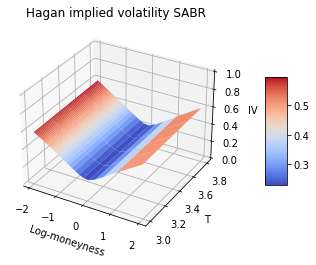

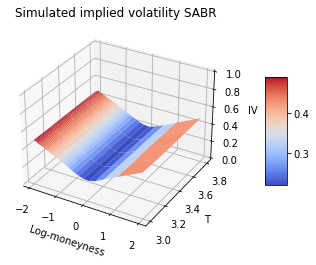

In [16]:
initial_price=100
initial_vol=0.2
volvol=0.7
Beta=1
p=0
ylim=(0,1)

surface_SABR_Hagan(initial_price,initial_vol, volvol, p, "Figure1_Hagan",ylim)
surface_SABR(initial_price,initial_vol, volvol, p, "Figure1_SABR", 10000,ylim)

- Initial volatility/ $\sigma_0$: 0.2
- Volvol/ $\alpha$: 0.7
- B: 1
- p: -0.8

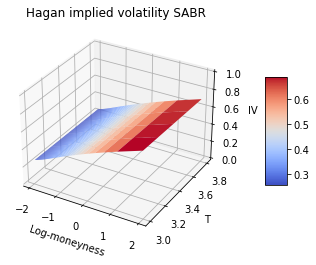

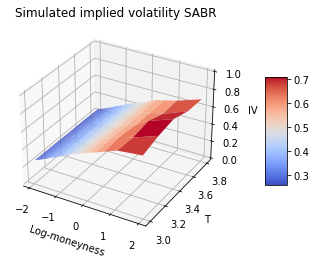

In [15]:
initial_price=100
initial_vol=0.6
volvol=0.3
Beta=1
p=-0.95
ylim=(0,1)


surface_SABR_Hagan(initial_price,initial_vol, volvol, p, "Figure2_Hagan",ylim)
surface_SABR(initial_price,initial_vol, volvol, p, "Figure2_SABR", 10000,ylim)

##### p= 0.95

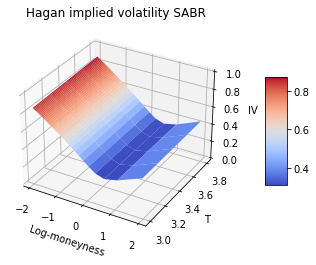

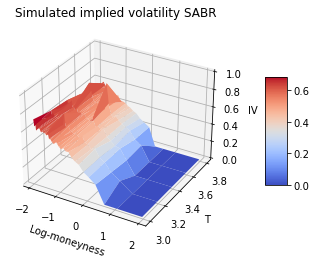

In [17]:
initial_price=100
initial_vol=0.35
volvol=0.6
Beta=1
p=0.75
ylim=(0,1)


surface_SABR_Hagan(initial_price,initial_vol, volvol, p, "Figure3_Hagan",ylim)
surface_SABR(initial_price,initial_vol, volvol, p, "Figure3_SABR", 10000,ylim)

### Heston implied volatility surface simulation

In [18]:
def payoff_simulation_Heston(initial_vol,theta, volvol ,T,K,p):
    n=1000
    dt=T/n
    time=np.array([0]*n,dtype=object)
    
    v1=np.array([0]*n,dtype=object)
    v1[0]=initial_vol
    Zt1=np.array([0]*n,dtype=object)
    dZ1=np.array([0]*n,dtype=object)
    
    v2=np.array([0]*n,dtype=object)
    v2[0]=initial_vol
    Zt2=np.array([0]*n,dtype=object)
    dZ2=np.array([0]*n,dtype=object)
    
    #generate the volatility process
    for i in range(1,n):
        time[i]=time[i-1]+dt
        
        Zt1[i]=Zt1[i-1]+np.random.normal(0,np.sqrt(dt))
        dZ1[i-1]=Zt1[i]-Zt1[i-1]
        dZ2[i-1]=-dZ1[i-1]
        Zt2[i]=Zt2[i-1]+dZ2[i-1]  
        
        vol_drift1=k*(theta-v1[i-1])
        vol_drift2=k*(theta-v2[i-1])       
        
        dv1=vol_drift1*dt + (volvol*np.power(v1[i-1],0.5)*dZ1[i-1]) + ((volvol*volvol)/4)*((dZ1[i-1]**2)-dt)
        dv2=vol_drift2*dt + (volvol*np.sqrt(v2[i-1])*dZ2[i-1]) + ((volvol*volvol)/4)*((dZ2[i-1]**2)-dt)
    
        v1[i]=v1[i-1]+dv1  
        v2[i]=v2[i-1]+dv2
        
        v1[i][v1[i]<0] = 0
        v2[i][v2[i]<0] = 0 
        
    #pay1
    v0=v1.sum()*dt
    v0=np.sqrt(v0/T)
        
    sqrt_v1=np.power(v1,0.5)
    E=p*sum(sqrt_v1*dZ1)-(((p**2)/2)*v0**2)*T
    S0=initial_price*np.exp(E)

    #vol, initial_price, r, T, K
    pay1=bs_price(v0*np.sqrt(1-p**2),S0,0,T, K)
    
    #####2
    v0=v2.sum()*dt
    v0=np.sqrt(v0/T)
        
    sqrt_v2=np.power(v2,0.5)
    E=p*sum(sqrt_v2*dZ2)-(((p**2)/2)*v0**2)*T
    S0=initial_price*np.exp(E)
        
    #vol, initial_price, r, T, K
    pay2=bs_price(v0*np.sqrt(1-p**2),S0,0,T, K) 
        
    #antithetic payoff
    pay=(pay1+pay2)/2
        
    return pay

    
def surface_Heston(initial_price, initial_vol, r, k, theta, volvol, name,m, ylim):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    T = np.arange(0.2,4.5,0.1) #maturities
    K = np.arange(50, 200, 10) #strikes
    T, K = np.meshgrid(T, K)
    size=T.shape #size of the meshgrid
    log_moneyness=np.log(initial_price/K) #log-moneyness
    moneyness=initial_price/K #moneyness

    #compute option prices for each T,K
    P=0 #to store mean of simulated payoffs
    for i in range(m):
        pay=payoff_simulation_Heston(initial_vol,theta, volvol ,T,K,p)
        P=P+pay
    P=P/m
    
    #compute implied volatilities of the prices
    IV=P.copy() #copying size
    for i in range (size[0]):
        for j in range(size[1]):
            IV[i][j]= implied_vol(initial_price,0,T[i][j],K[i][j],P[i][j])


    # Plot the surface
    surf = ax.plot_surface(T*12,moneyness, IV,cmap=cm.coolwarm)#cm.jet

    # Customize the z axis.
    ax.set_zlim(ylim[0], ylim[1]) 

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.12)

    #Axis and titles
    ax.set_xlabel('T in months')
    ax.set_ylabel('Moneyness')
    ax.set_zlabel('IV')
    plt.title("Simulated implied volatility Heston")

    #if there is a name, save figure
    if name!=" ":
        plt.savefig(name+".png")
        
    plt.show()

In [19]:
initial_price=100
r=0

##### Figure 1 Heston

- Initial volatility/ $\sigma_0$: 0.8
- Long term volatility/ $\theta$: 0.1
- p: 0.0
- Mean reversion (k): 2
- Volvol: 0.8

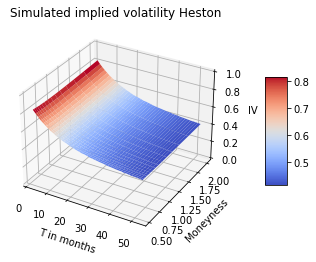

In [26]:
initial_vol=0.8
theta=0.1
p=0
k=2
volvol=0.8
ylim=(0,1)

surface_Heston(initial_price, initial_vol, r, k, theta, volvol,"Figure1_Heston",1000,ylim)

##### Figure 2 Heston

- Initial volatility/ $\sigma_0$: 0.4
- Long term volatility/ $\theta$: 0.1
- p: 0.3
- Mean reversion (k): 4
- Volvol: 0.6

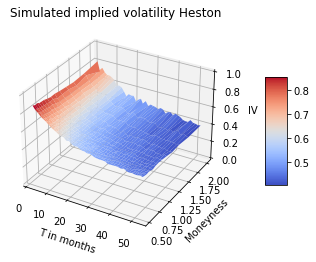

In [23]:
initial_vol=0.8
theta=0.1
p=0.3
k=2
volvol=0.8
ylim=(0,1)

surface_Heston(initial_price, initial_vol, r, k, theta, volvol, "Figure2_Heston",1000,ylim)

##### Figure 3 Heston

- Initial volatility/ $\sigma_0$: 0.1
- Long term volatility/ $\theta$: 0.1
- p: 0
- Mean reversion (k): 2
- Volvol: 1

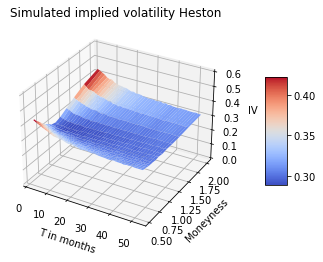

In [24]:
initial_vol=0.1
theta=0.1
p=0
k=2
volvol=1
ylim=(0,0.6)


surface_Heston(initial_price, initial_vol, r, k, theta, volvol, "Figure3_Heston",1000, ylim)

##### Figure 3 Heston

- Initial volatility/ $\sigma_0$: 0.5
- Long term volatility/ $\theta$: 1
- p: 0
- Mean reversion (k): 3
- Volvol: 0.3

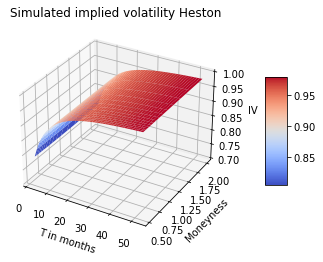

In [25]:
initial_vol=0.5
theta=1
p=0
k=3
volvol=0.3
ylim=(0.7,1)


surface_Heston(initial_price, initial_vol, r, k, theta, volvol, "Figure4_Heston",1000,ylim)